# Example ConvNet project

With filenames and correlation labels in `responses.csv`, and images in `images/`, this notebook trains a simple convnet model that predicts these correlation labels. The module `data` contains classes to read and preprocess the data. The module `model` contains the simple convnet used here.

In [1]:
import pandas as pd
import os
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn

from data import TrainTestSplitter, CorrelationDataset, CorrelationTransform
from model import CorrelationNet

In [2]:
# Load labels
labels = pd.read_csv('responses.csv')
# Check if all files are available
assert set(labels.id) == set([fn[:-4] for fn in os.listdir('images')]), "File id's in responses.csv do not correspond to files in images/"

### Preprocessing

In [3]:
FILE_RESPONSES = 'responses.csv'
DIR_IMG = 'images'

# Splitter for train/test split
train_test_splitter = TrainTestSplitter(
    test_ratio=0.2,
    seed=42
)
# Create data loaders for train and test data
train_dataset = CorrelationDataset(
    FILE_RESPONSES,
    DIR_IMG,
    train_test_splitter,
    train=True,
    transform=CorrelationTransform(True)
)
test_dataset = CorrelationDataset(
    FILE_RESPONSES,
    DIR_IMG,
    train_test_splitter,
    train=False,
    transform=CorrelationTransform(False)
)
train_dataloader = DataLoader(
    train_dataset, 
    batch_size=64, 
    shuffle=True,
    num_workers=10
)
test_dataloader = DataLoader(
    test_dataset, 
    batch_size=64, 
    shuffle=True,
    num_workers=10
)

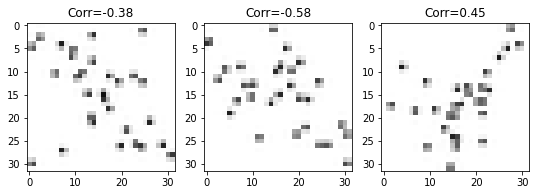

In [4]:
train_features, train_labels = next(iter(train_dataloader))
fig, axes = plt.subplots(figsize=(9,3), ncols=3)
for i in range(3):
    axes[i].imshow(train_features[i].permute((1,2,0)))
    axes[i].set_title('Corr={:.2f}'.format(train_labels[i]))
plt.show()

### Training

In [5]:
net = CorrelationNet()

print(net)
print("Number of params: {}".format(
    sum([np.product(p.shape) for p in net.parameters()])
))

CorrelationNet(
  (model): Sequential(
    (0): Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(20, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(20, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=160, out_features=64, bias=True)
    (11): ReLU()
    (12): Linear(in_features=64, out_features=16, bias=True)
    (13): ReLU()
    (14): Linear(in_features=16, out_features=1, bias=True)
    (15): Tanh()
  )
)
Number of params: 24711


In [6]:
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [7]:
# Performance before training
def evaluate(net, dataloader, criterion):
    losses = []
    with torch.no_grad():
        for data in tqdm(dataloader, leave=False):
            images, labels = data
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            losses.append(criterion(outputs, labels.view(-1,1)))
    return np.mean(losses)

print("Test MSE: {}".format(
    evaluate(net, test_dataloader, criterion)
))

  0%|          | 0/469 [00:00<?, ?it/s]

Test MSE: 0.25001323223114014


In [8]:
# Tracking performance and managing early stopping
early_stopping_best_mse = 2
early_stopping_patience = 0
early_stopping_best_model = net.state_dict()
mse_train = defaultdict(lambda: []) # Store batch mse in lists as {epoch: [mse]}
mse_test = []

# Evaluate test mse before training
mse = evaluate(net, test_dataloader, criterion)
mse_test.append(mse)
early_stopping_best_mse = mse
print('[00       ] Test MSE: {:.3f}'.format(mse))

# Train loops
for epoch in tqdm(range(20)):  # epochs
    for i, data in tqdm(enumerate(train_dataloader), leave=False, total=len(train_dataloader)):
        # get the inputs; data is a list of [inputs, labels]
        images, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(images)
        loss = criterion(outputs, labels.view(-1, 1))
        loss.backward()
        optimizer.step()

        # print train statistics
        mse_train[epoch].append(loss.detach().numpy())
        if i % 200 == 199:    # print every 200 mini-batches
            print('[{:2d}, {:5d}] Train batch MSE: {:.3f}'.format(
                epoch+1, i+1, loss
            ))

    # Evaluate test MSE and manage early stopping
    mse = evaluate(net, test_dataloader, criterion)
    mse_test.append(mse)
    print('[{:2d}       ] Test MSE: {:.3f}'.format(epoch+1, mse))
    if mse < early_stopping_best_mse:
        early_stopping_best_mse = mse
        early_stopping_best_model = net.state_dict()
        early_stopping_patience = 0
    else:
        if early_stopping_patience >= 2:
            print("Stopping early because test MSE did not improve for 2 consecutive epochs")
            break
        else:
            early_stopping_patience += 1
    
print('Finished Training')

  0%|          | 0/469 [00:00<?, ?it/s]

[00       ] Test MSE: 0.250


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

/home/silvan/anaconda3/envs/torch/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729096996/work/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


[ 1,   200] Train batch MSE: 0.210
[ 1,   400] Train batch MSE: 0.219
[ 1,   600] Train batch MSE: 0.221
[ 1,   800] Train batch MSE: 0.219
[ 1,  1000] Train batch MSE: 0.195
[ 1,  1200] Train batch MSE: 0.204
[ 1,  1400] Train batch MSE: 0.200
[ 1,  1600] Train batch MSE: 0.204
[ 1,  1800] Train batch MSE: 0.221


  0%|          | 0/469 [00:00<?, ?it/s]

[ 1       ] Test MSE: 0.179


  0%|          | 0/1875 [00:00<?, ?it/s]

[ 2,   200] Train batch MSE: 0.159
[ 2,   400] Train batch MSE: 0.024
[ 2,   600] Train batch MSE: 0.021
[ 2,   800] Train batch MSE: 0.015
[ 2,  1000] Train batch MSE: 0.015
[ 2,  1200] Train batch MSE: 0.011
[ 2,  1400] Train batch MSE: 0.017
[ 2,  1600] Train batch MSE: 0.018
[ 2,  1800] Train batch MSE: 0.011


  0%|          | 0/469 [00:00<?, ?it/s]

[ 2       ] Test MSE: 0.013


  0%|          | 0/1875 [00:00<?, ?it/s]

[ 3,   200] Train batch MSE: 0.016
[ 3,   400] Train batch MSE: 0.012
[ 3,   600] Train batch MSE: 0.009
[ 3,   800] Train batch MSE: 0.010
[ 3,  1000] Train batch MSE: 0.011
[ 3,  1200] Train batch MSE: 0.010
[ 3,  1400] Train batch MSE: 0.010
[ 3,  1600] Train batch MSE: 0.008
[ 3,  1800] Train batch MSE: 0.007


  0%|          | 0/469 [00:00<?, ?it/s]

[ 3       ] Test MSE: 0.009


  0%|          | 0/1875 [00:00<?, ?it/s]

[ 4,   200] Train batch MSE: 0.011
[ 4,   400] Train batch MSE: 0.009
[ 4,   600] Train batch MSE: 0.009
[ 4,   800] Train batch MSE: 0.008
[ 4,  1000] Train batch MSE: 0.009
[ 4,  1200] Train batch MSE: 0.007
[ 4,  1400] Train batch MSE: 0.008
[ 4,  1600] Train batch MSE: 0.007
[ 4,  1800] Train batch MSE: 0.007


  0%|          | 0/469 [00:00<?, ?it/s]

[ 4       ] Test MSE: 0.007


  0%|          | 0/1875 [00:00<?, ?it/s]

[ 5,   200] Train batch MSE: 0.004
[ 5,   400] Train batch MSE: 0.005
[ 5,   600] Train batch MSE: 0.008
[ 5,   800] Train batch MSE: 0.008
[ 5,  1000] Train batch MSE: 0.005
[ 5,  1200] Train batch MSE: 0.005
[ 5,  1400] Train batch MSE: 0.005
[ 5,  1600] Train batch MSE: 0.006
[ 5,  1800] Train batch MSE: 0.006


  0%|          | 0/469 [00:00<?, ?it/s]

[ 5       ] Test MSE: 0.006


  0%|          | 0/1875 [00:00<?, ?it/s]

[ 6,   200] Train batch MSE: 0.006
[ 6,   400] Train batch MSE: 0.005
[ 6,   600] Train batch MSE: 0.004
[ 6,   800] Train batch MSE: 0.007
[ 6,  1000] Train batch MSE: 0.004
[ 6,  1200] Train batch MSE: 0.006
[ 6,  1400] Train batch MSE: 0.005
[ 6,  1600] Train batch MSE: 0.004
[ 6,  1800] Train batch MSE: 0.005


  0%|          | 0/469 [00:00<?, ?it/s]

[ 6       ] Test MSE: 0.004


  0%|          | 0/1875 [00:00<?, ?it/s]

[ 7,   200] Train batch MSE: 0.005
[ 7,   400] Train batch MSE: 0.004
[ 7,   600] Train batch MSE: 0.004
[ 7,   800] Train batch MSE: 0.003
[ 7,  1000] Train batch MSE: 0.004
[ 7,  1200] Train batch MSE: 0.007
[ 7,  1400] Train batch MSE: 0.003
[ 7,  1600] Train batch MSE: 0.004
[ 7,  1800] Train batch MSE: 0.003


  0%|          | 0/469 [00:00<?, ?it/s]

[ 7       ] Test MSE: 0.004


  0%|          | 0/1875 [00:00<?, ?it/s]

[ 8,   200] Train batch MSE: 0.004
[ 8,   400] Train batch MSE: 0.004
[ 8,   600] Train batch MSE: 0.003
[ 8,   800] Train batch MSE: 0.005
[ 8,  1000] Train batch MSE: 0.003
[ 8,  1200] Train batch MSE: 0.003
[ 8,  1400] Train batch MSE: 0.004
[ 8,  1600] Train batch MSE: 0.003
[ 8,  1800] Train batch MSE: 0.006


  0%|          | 0/469 [00:00<?, ?it/s]

[ 8       ] Test MSE: 0.004


  0%|          | 0/1875 [00:00<?, ?it/s]

[ 9,   200] Train batch MSE: 0.004
[ 9,   400] Train batch MSE: 0.005
[ 9,   600] Train batch MSE: 0.003
[ 9,   800] Train batch MSE: 0.003
[ 9,  1000] Train batch MSE: 0.004
[ 9,  1200] Train batch MSE: 0.004
[ 9,  1400] Train batch MSE: 0.002
[ 9,  1600] Train batch MSE: 0.003
[ 9,  1800] Train batch MSE: 0.003


  0%|          | 0/469 [00:00<?, ?it/s]

[ 9       ] Test MSE: 0.003


  0%|          | 0/1875 [00:00<?, ?it/s]

[10,   200] Train batch MSE: 0.003
[10,   400] Train batch MSE: 0.003
[10,   600] Train batch MSE: 0.003
[10,   800] Train batch MSE: 0.003
[10,  1000] Train batch MSE: 0.002
[10,  1200] Train batch MSE: 0.004
[10,  1400] Train batch MSE: 0.003
[10,  1600] Train batch MSE: 0.002
[10,  1800] Train batch MSE: 0.003


  0%|          | 0/469 [00:00<?, ?it/s]

[10       ] Test MSE: 0.003


  0%|          | 0/1875 [00:00<?, ?it/s]

[11,   200] Train batch MSE: 0.003
[11,   400] Train batch MSE: 0.002
[11,   600] Train batch MSE: 0.003
[11,   800] Train batch MSE: 0.004
[11,  1000] Train batch MSE: 0.004
[11,  1200] Train batch MSE: 0.002
[11,  1400] Train batch MSE: 0.003
[11,  1600] Train batch MSE: 0.003
[11,  1800] Train batch MSE: 0.005


  0%|          | 0/469 [00:00<?, ?it/s]

[11       ] Test MSE: 0.003


  0%|          | 0/1875 [00:00<?, ?it/s]

[12,   200] Train batch MSE: 0.002
[12,   400] Train batch MSE: 0.003
[12,   600] Train batch MSE: 0.003
[12,   800] Train batch MSE: 0.003
[12,  1000] Train batch MSE: 0.004
[12,  1200] Train batch MSE: 0.002
[12,  1400] Train batch MSE: 0.002
[12,  1600] Train batch MSE: 0.003
[12,  1800] Train batch MSE: 0.002


  0%|          | 0/469 [00:00<?, ?it/s]

[12       ] Test MSE: 0.003


  0%|          | 0/1875 [00:00<?, ?it/s]

[13,   200] Train batch MSE: 0.003
[13,   400] Train batch MSE: 0.002
[13,   600] Train batch MSE: 0.002
[13,   800] Train batch MSE: 0.002
[13,  1000] Train batch MSE: 0.003
[13,  1200] Train batch MSE: 0.004
[13,  1400] Train batch MSE: 0.002
[13,  1600] Train batch MSE: 0.003
[13,  1800] Train batch MSE: 0.002


  0%|          | 0/469 [00:00<?, ?it/s]

[13       ] Test MSE: 0.003


  0%|          | 0/1875 [00:00<?, ?it/s]

[14,   200] Train batch MSE: 0.003
[14,   400] Train batch MSE: 0.003
[14,   600] Train batch MSE: 0.002
[14,   800] Train batch MSE: 0.004
[14,  1000] Train batch MSE: 0.002
[14,  1200] Train batch MSE: 0.003
[14,  1400] Train batch MSE: 0.002
[14,  1600] Train batch MSE: 0.002
[14,  1800] Train batch MSE: 0.002


  0%|          | 0/469 [00:00<?, ?it/s]

[14       ] Test MSE: 0.002


  0%|          | 0/1875 [00:00<?, ?it/s]

[15,   200] Train batch MSE: 0.003
[15,   400] Train batch MSE: 0.003
[15,   600] Train batch MSE: 0.003
[15,   800] Train batch MSE: 0.002
[15,  1000] Train batch MSE: 0.002
[15,  1200] Train batch MSE: 0.002
[15,  1400] Train batch MSE: 0.002
[15,  1600] Train batch MSE: 0.003
[15,  1800] Train batch MSE: 0.003


  0%|          | 0/469 [00:00<?, ?it/s]

[15       ] Test MSE: 0.002


  0%|          | 0/1875 [00:00<?, ?it/s]

[16,   200] Train batch MSE: 0.003
[16,   400] Train batch MSE: 0.003
[16,   600] Train batch MSE: 0.002
[16,   800] Train batch MSE: 0.002
[16,  1000] Train batch MSE: 0.003
[16,  1200] Train batch MSE: 0.002
[16,  1400] Train batch MSE: 0.002
[16,  1600] Train batch MSE: 0.002
[16,  1800] Train batch MSE: 0.002


  0%|          | 0/469 [00:00<?, ?it/s]

[16       ] Test MSE: 0.002


  0%|          | 0/1875 [00:00<?, ?it/s]

[17,   200] Train batch MSE: 0.002
[17,   400] Train batch MSE: 0.002
[17,   600] Train batch MSE: 0.002
[17,   800] Train batch MSE: 0.002
[17,  1000] Train batch MSE: 0.003
[17,  1200] Train batch MSE: 0.002
[17,  1400] Train batch MSE: 0.002
[17,  1600] Train batch MSE: 0.002
[17,  1800] Train batch MSE: 0.002


  0%|          | 0/469 [00:00<?, ?it/s]

[17       ] Test MSE: 0.002


  0%|          | 0/1875 [00:00<?, ?it/s]

[18,   200] Train batch MSE: 0.002
[18,   400] Train batch MSE: 0.002
[18,   600] Train batch MSE: 0.003
[18,   800] Train batch MSE: 0.002
[18,  1000] Train batch MSE: 0.002
[18,  1200] Train batch MSE: 0.002
[18,  1400] Train batch MSE: 0.003
[18,  1600] Train batch MSE: 0.003
[18,  1800] Train batch MSE: 0.002


  0%|          | 0/469 [00:00<?, ?it/s]

[18       ] Test MSE: 0.002


  0%|          | 0/1875 [00:00<?, ?it/s]

[19,   200] Train batch MSE: 0.004
[19,   400] Train batch MSE: 0.001
[19,   600] Train batch MSE: 0.003
[19,   800] Train batch MSE: 0.002
[19,  1000] Train batch MSE: 0.002
[19,  1200] Train batch MSE: 0.002
[19,  1400] Train batch MSE: 0.001
[19,  1600] Train batch MSE: 0.002
[19,  1800] Train batch MSE: 0.002


  0%|          | 0/469 [00:00<?, ?it/s]

[19       ] Test MSE: 0.002


  0%|          | 0/1875 [00:00<?, ?it/s]

[20,   200] Train batch MSE: 0.003
[20,   400] Train batch MSE: 0.002
[20,   600] Train batch MSE: 0.003
[20,   800] Train batch MSE: 0.002
[20,  1000] Train batch MSE: 0.002
[20,  1200] Train batch MSE: 0.002
[20,  1400] Train batch MSE: 0.003
[20,  1600] Train batch MSE: 0.002
[20,  1800] Train batch MSE: 0.002


  0%|          | 0/469 [00:00<?, ?it/s]

[20       ] Test MSE: 0.002
Finished Training


### Analysis

In [9]:
# Obtain best model and store it
torch.save(early_stopping_best_model, 'best_model.pth')
net.load_state_dict(early_stopping_best_model)

<All keys matched successfully>

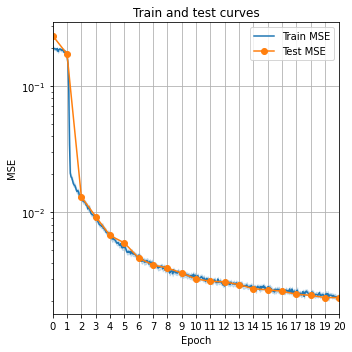

In [26]:
# Plot train and test metrics
batches_per_epoch = len(mse_train[0])
n_epochs = len(mse_train)
xs_train = [epoch*batches_per_epoch + batch for epoch in range(n_epochs) for batch in range(batches_per_epoch)]
xs_train = np.array(xs_train) // 100 * 100 # accumulate per 100 batches
ys_train = np.array([mse for epoch in range(n_epochs) for mse in mse_train[epoch]])
xs_test  = [epoch*batches_per_epoch for epoch in range(n_epochs+1)]

fig, ax = plt.subplots(figsize=(5,5))
sns.lineplot(
    x=xs_train,
    y=ys_train,
    label='Train MSE',
    ax=ax
)
ax.plot(
    xs_test,
    mse_test,
    '-o',
    label='Test MSE'
)
ax.grid()
ax.legend()
ax.set(
    ylabel="MSE",
    xlabel='Epoch',
    title='Train and test curves',
    xticks=xs_test,
    xticklabels=range(n_epochs+1),
    yscale='log',
    xlim=(0,max(xs_test))
)
plt.tight_layout()
plt.show()

In [18]:
mse_test

[0.2499338,
 0.17884767,
 0.013272135,
 0.009275006,
 0.0065690093,
 0.0057406044,
 0.004363976,
 0.0038360115,
 0.0036405434,
 0.003312513,
 0.0029793966,
 0.0028512955,
 0.0028214178,
 0.0026854954,
 0.0024906883,
 0.0024422512,
 0.0023802626,
 0.0022539417,
 0.0022071884,
 0.002122604,
 0.0021187265]

(tensor(-0.4833), tensor([-0.4916], grad_fn=<SelectBackward>))

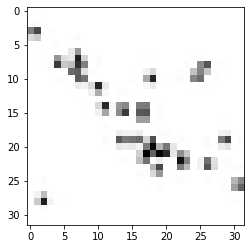

In [27]:
# Plot example prediction
i = 1
plt.imshow(images[i].permute((1,2,0)))
labels[i], outputs[i]